# データを読み込む
ライブラリの`pandas`を用いてデータを読み込みます．

In [38]:
import pandas as pd

# 全データを読み込む
data = pd.read_csv('international-airline-passengers.csv')

data = data.iloc[:,1]

print(len(data))
data.head()

144


0    112
1    118
2    132
3    129
4    121
Name: IAP, dtype: int64

# データを図示してみる
本実験では`International Airline Passengers`を利用して時系列予測を行うこととします．どのようなデータなのかを確認するため，図示します．また，データの値のtypeがintのままだと後程の計算に支障が出るため，floatに変換します．

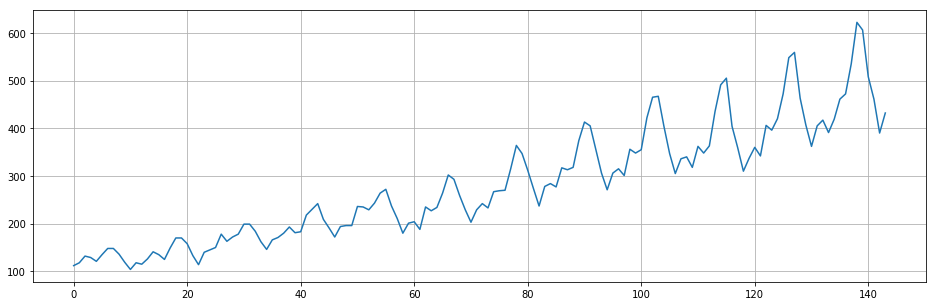

In [39]:
import matplotlib.pyplot as plt
# pandasのデータをplotする際にWarning避けのためにimport
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# jupyter notebook上で図を表示するために挿入
%matplotlib inline

# 値のtypeをintからfloatに変更する．
data = data.astype(float)

# 図示する
plt.figure(figsize=(16,5))
plt.grid()

plt.plot(data);

# データの性質を確認する
得られたグラフを確認すると，年を追うごとに数値が何かのトレンドをもって増加していることが確認できます．通常，観測するデータはある確率を背景に実測されるものです．時系列データが変化してゆく様を過程といい，一般的にこのある確率を背景に生成される時系列データの実測値のことを**確率過程**と呼びます．

確率過程の中でも時系列データの統計的な解析を行う際には「**定常過程**」，「**非定常過程**」の2つを押さえておく必要があります．定常過程は時間や位置によって確率分布が変化しない確率過程，つまり平均や分散が変化しない確率過程です(つまり，非定常はこの逆で，平均や分散が時間や位置によって変動する確率過程となります)．一般的に統計解析はデータの確率過程が定常過程でなければ意味がないとされています．非定常過程の場合，平均や分散が時系列の区間によってばらつくことが考えられ，それを利用する統計値，つまり今回のケースでは予測値がもっとばらつくと考えられ，到底使えるデータではなくなってしまうからです．

よって，データが定常過程にする必要があります．そのために，**単位根検定**という検定を行います．以下で単位根過程に関する定義を確認します．

>原系列$y_t$が非定常過程であり，差分系列$\Delta y_t = y_t−y_{t−1}$が定常過程であるとき，過程は単位根過程(unit root process)といわれる．
(沖本竜義(2010), "経済・ファイナンスデータの計量時系列分析", P. 105, 朝倉書店より引用)

単位根検定により棄却されなければこのデータは単位根過程**ではないとは言えない**ということが分かり，差分系列を取ることによって定常過程になる可能性があることがわかります．

In [40]:
import statsmodels.api as sm

sm.tsa.stattools.adfuller(data)

(0.8153688792060543,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

# データの差分系列を取る
単位根検定により，2行目の項目である**P値**が0.99となっており0.05より大きいことがわかったため，この時系列データは単位根過程ではないとはいえなさそうです．よって，差分系列を取ることによって定常過程にすることができる可能性があります．

差分系列とは，時系列データの中で1次点離れたデータとの差を取ったデータ$\Delta y_t = y_t - y_{t-1}$のことを指します．

> P値は，統計的仮説検定において，**帰無仮説**の元で検定統計量がその値となる確率のことを指します．P値が小さいほど，検定統計量がその値となることはあまり起こり得ないことを意味します．一般的に，P値が5%または1%以下の場合に帰無仮説を偽として棄却し，**対立仮説**を採択します．
本実験ではP値が1.0となっているので帰無仮説を採択することになります。

In [41]:
# データの差分をとる
datadiff = data.diff()

# NaNを削除する
datadiff = datadiff.dropna()
datadiff.head()

1     6.0
2    14.0
3    -3.0
4    -8.0
5    14.0
Name: IAP, dtype: float64

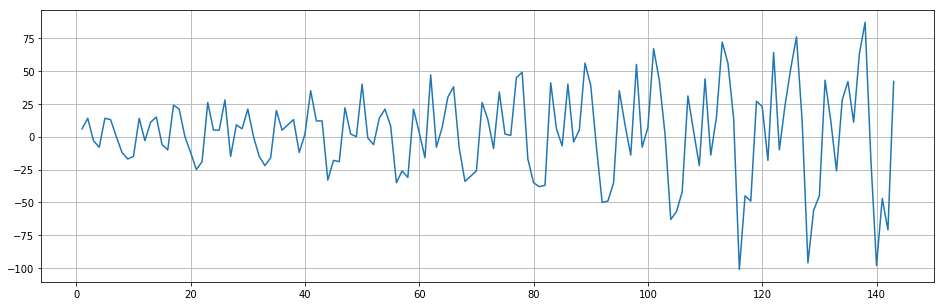

In [42]:
# 図示する
plt.figure(figsize=(16,5))
plt.grid()

plt.plot(datadiff);

# 自己相関・偏自己相関グラフの推定
**自己相関**とは，現在$t$とその$k$時点前の$t-k$の**自己共分散**

$$
Cov(y_t,y_{t-k}) = E[(y_t - \mu_t)(y_{t-k} - \mu_{t-k})]
$$

を基準化した

$$
\rho(k) = Corr(y_t,y_{t-k}) = \dfrac{Cov(y_t,y_{t-k})}{\sqrt{Var(y_t)Var({y_{t-k}})}}
$$

となります．自己共分散のままだと，値の大きさが単位依存となります．それらを基準化することで**異なる時点間でのその過程の関係性(相関)の存在の有無を表す指標**としました．例えば，自己相関が全くないもの($t=0$以外での自己相関が0)となると，単なるホワイトノイズということになります．

しかし，自己相関を調べるだけでは特徴が解釈しづらい場合もあります．例えば，「一昨日と今日」の自己相関を知りたいとしたとき，「昨日と今日」の自己相関が高ければ，「一昨日と今日」の自己相関も高いことが予想されます．何故なら，「昨日」時点の情報がその中に織り込み済みだからです．「一昨日と今日」の**真の自己相関**を知るためには，「昨日」時点の情報を取り除く必要があります．この真の自己相関のことを**偏自己相関**といいます．

現在$t$とその$k$時点前の$t-k$の偏自己相関は，$k-1$個のデータ$y_{t-k+1},\ldots,y_{t-1}$の影響を取り除いたあとの自己相関となります．その偏自己相関は，次の方程式において$\varphi_i$として求まることが知られています．

$$
\left(
\begin{array}{cccc}
    1         & \rho(1)   & \cdots & \rho(k-1) \\
    \rho(1)   & 1         & \cdots & \rho(k-2) \\
    \vdots    & \vdots    & \ddots & \vdots    \\
    \rho(k-1) & \rho(k-2) & \cdots & 1         \\
\end{array}
\right)
\left(
\begin{array}{c}
\varphi_1 \\
\varphi_2 \\
\vdots    \\
\varphi_k
\end{array}
\right) = 
\left(
\begin{array}{c}
\rho(1) \\
\rho(2) \\
\vdots  \\
\rho(k)
\end{array}
\right)
$$

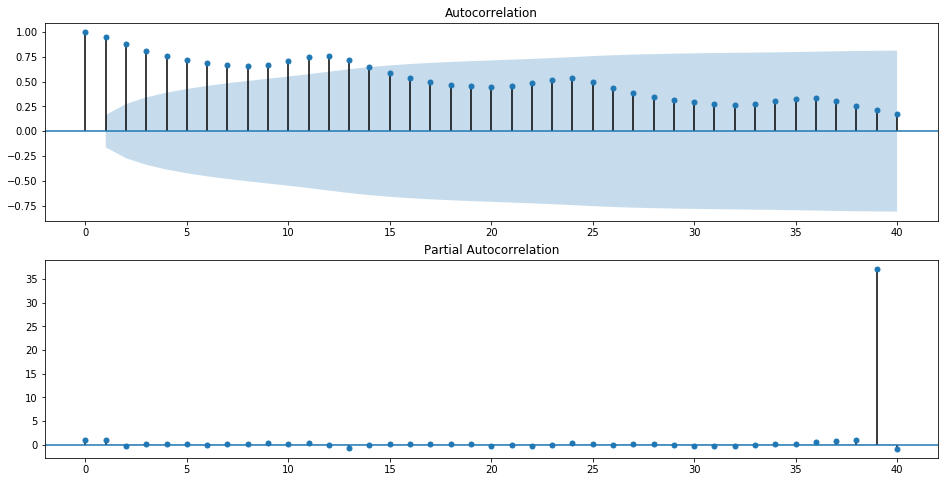

In [43]:
# 自己相関・偏自己相関のグラフ
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax2)

水色の部分は**95%の信頼区間**となります．

> $\alpha$%信頼区間とは，母平均が$\alpha$%の確率でその範囲に存在することを意味しています．母平均は母集団の平均で決まった値になるので産出された信頼区間に母平均が含まれるか，含まれないかのどちらかとなります．

1つ目の自己相関のグラフを見るとどの部分でも正の相関を持っており，一見するとどこに特徴があるのかがわかりにくいです．2つ目の偏自己相関のグラフは特定の時間のみとの自己相関を見ているので，特徴が分かりやすくなっています．見てみると，11から13ヶ月程度の周期の相関が見られます．

# ARIMAモデルの推定
**ARIMA(AutoRegressive Integrated Moving Average)モデル** は，データの差分を取ってから**ARMA(AutoRegressive Moving Average)** を適用したモデルです．ARMAモデルは**AR(AutoRegression)** と**MA(Moving Average)** を組み合わせたモデルです．

### * AR(AutoRegression) - 自己回帰モデル

時系列モデルの中で一番シンプルなモデルです．その名の通り，自分のデータと回帰を行う手法です．時刻$p$前までのデータを使ってデータの予測を行うモデルはAR($p$)と書きます．


###  * MA(Moving Average) - 移動平均モデル

通常の移動平均の説明をまず行います．

$$
4, \ 5, \ 9, \ 13, \ 17
$$

というデータがあるとします．例えばこれを3区間移動平均を行うと，

$$
\begin{align*}
\dfrac{4 + 5 + 9}{3} = 6, \quad
\dfrac{5 + 9 + 13}{3} = 9, \quad
\dfrac{9 + 13 + 17}{3} = 13 
\end{align*}
$$

となります．つまり，区間3の平均を1つずつずらしながら行うと3区間の移動平均となります．また，それぞれの結果を見ると同じ数字を利用して移動平均の結果を出していることがわかります．よって，「移動平均のように，一部同じ数を使用して表されたデータは自己相関をもつ」という考え方を利用したのが移動平均モデルとなります．$q$区間移動平均モデルはMA($q$)と表記します．


### * ARMA(AutoRegressive Moving Average) - 自己回帰移動平均モデル

その名の通りですが，上記2つのモデルを組み合わせたモデルです．このモデルはARMA($p, q$)と表記します．


### * ARIMA(AutoRegressive Integrated Moving Average) - 自己回帰和分移動平均モデル

データに対して差分を取り，それからARMAを適用したモデルとなります．差分を取る回数をパラメータ$d$として，このモデルはARIMA($p,d,q$)と表記します．


pythonではARIMAのパラメータを自動推定するライブラリはないため，予め差分をとったデータに対してARMAのパラメータを自動推定することとします．本実験では1回差分を取り，そのデータに対してARMAのパラメータの自動推定を行いました．

In [44]:
# ワーニングを表示させない
import warnings
warnings.filterwarnings('ignore')

# 差分系列への自動ARMA推定関数の実行
resDiff = sm.tsa.arma_order_select_ic(datadiff, ic='aic', trend='nc')
resDiff

{'aic':              0            1            2
 0          NaN  1397.257791  1397.093436
 1  1401.852641  1412.615224  1385.496795
 2  1396.587654  1378.338024  1353.175678
 3  1395.021214  1379.614000  1351.138642
 4  1388.216680  1379.616584  1373.560615, 'aic_min_order': (3, 2)}

AICは**赤池情報量基準(AIC:Akaike's Information Criterion)** を指します．この基準は統計モデルの良さを評価するための指標です．このAICが最小となるモデルを選択すると，一般的に良いモデルが選択できるといわれています．本実験ではAICが最小となる$p,q$の組み合わせが$3,2$ということなので，ARIMAモデルに対して$p=3, \ q=2$とします．

In [45]:
from statsmodels.tsa.arima_model import ARIMA

# p=2, q=1 が最善となったので、それをモデル化
# d=1は差分を取った回数．今回は1回
ARIMA_2_1_1 = ARIMA(data, order=(3, 1, 2)).fit(dist=False)
ARIMA_2_1_1.params

const          2.673499
ar.L1.D.IAP    0.261993
ar.L2.D.IAP    0.367828
ar.L3.D.IAP   -0.363474
ma.L1.D.IAP   -0.075060
ma.L2.D.IAP   -0.924855
dtype: float64

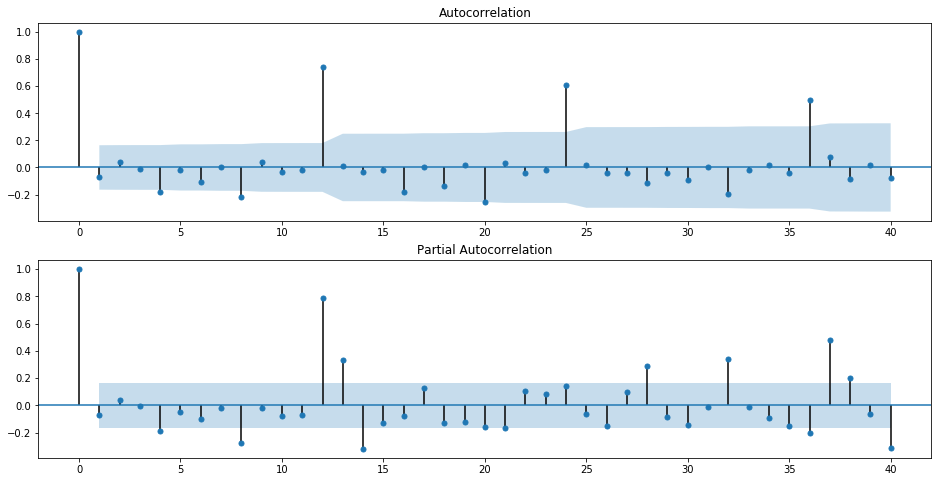

In [46]:
resid = ARIMA_2_1_1.resid
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

この図を見ると，12か月周期で高い自己相関が表れていることがわかります．つまり，ある程度の周期性があるにも関わらずそれを考慮できていない結果となることが予想されます．

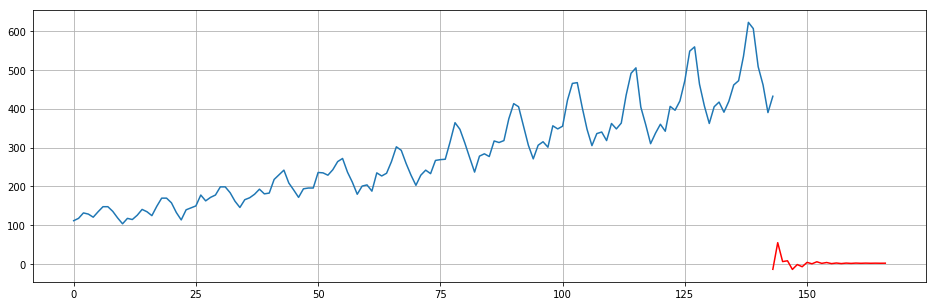

In [52]:
# 予測結果の出力
pred = ARIMA_2_1_1.predict(143,166)

# 実データと予測結果の図示
plt.figure(figsize=(16,5))
plt.grid()

plt.plot(data.values)
plt.plot(pred, "r");

目も当てられない結果になってしまっています．次に，周期性も考慮するSARIMAモデルでの予測を試みます．

# SARIMAモデルの推定
**SARIMA(Seasonal ARIMA)** はARIMAモデルに対してさらに周期的な変動を取り入れたモデルとなります．

In [48]:
# パラメータを決め打ちで設定したSARIMAモデルを作成する

SARIMA_2_1_1_111 = sm.tsa.SARIMAX(data, order=(3,1,2), seasonal_order=(1,1,1,12)).fit()
SARIMA_2_1_1_111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                IAP   No. Observations:                  144
Model:             SARIMAX(3, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -502.966
Date:                            Wed, 19 Jun 2019   AIC                           1021.933
Time:                                    23:40:08   BIC                           1044.934
Sample:                                         0   HQIC                          1031.279
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6754      1.547      0.436      0.663      -2.358       3.708
ar.L2          0.2059      0.919      0.224      0.823      -1.595       2.007
ar.L3         -0.0717      0.359     -0.200      0.842      -0.776       0.633
ma.L1         -1.0611      1.574     -0.674      0.500      -4.146       2.024
ma.L2          0.0837      1.541      0.054      0.957      -2.937       3.104
ar.S.L12      -0.8653      0.289     -2.993      0.003      -1.432      -0.299
ma.S.L12       0.7666      0.373      2.055      0.040       0.035       1.498
sigma2       124.8692     14.373      8.688      0.000      96.699     153.039
===================================================================================
Ljung-Box (Q):                       50.90   Jarque-Bera (JB):                14.10
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               2.60   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

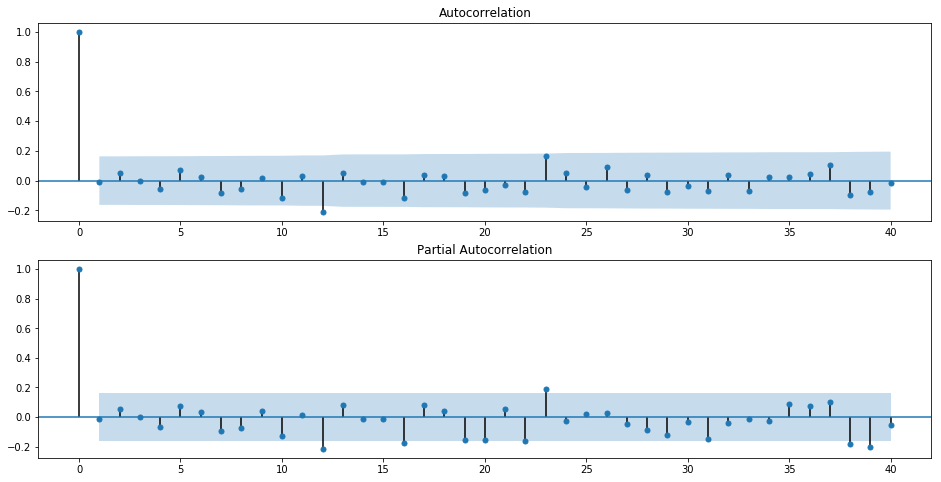

In [49]:
# 残差のチェック
residSARIMA = SARIMA_2_1_1_111.resid
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

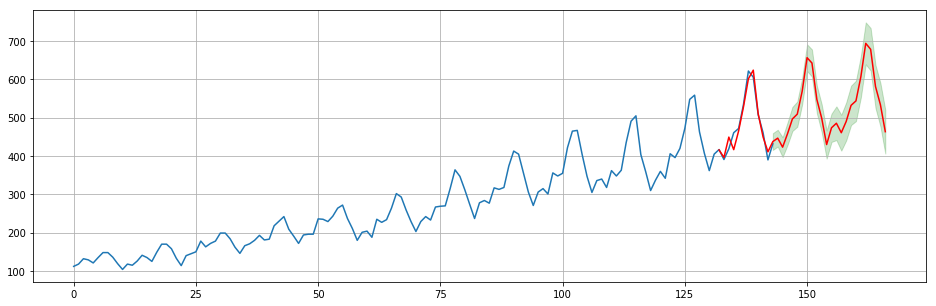

In [53]:
# 予測結果の出力
pred = SARIMA_2_1_1_111.predict(132,166)

# 予測結果の信頼区間の出力
pred_dy = SARIMA_2_1_1_111.get_prediction(143,166)
pred_dy_cl = pred_dy.conf_int(alpha=0.05)

# 実データと予測結果の図示
plt.figure(figsize=(16,5))
plt.grid()

plt.fill_between(pred_dy_cl.index, pred_dy_cl.iloc[:,0], pred_dy_cl.iloc[:,1], color="g", alpha=0.2)
plt.plot(data)
plt.plot(pred, "r");

ある程度綺麗に予測できているのではないでしょうか．